# Patentamens

Notebook para cálculo de estadisticas del juego de las patentes

## Setup

Leemos el archivo que contiene los datos `data.csv` para procesarlos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def read_data():
    # Read the data from the csv file
    data = pd.read_csv("data.csv")

    # convert the data to a dataframe
    df = pd.DataFrame(data)

    # convert fecha to datetime
    df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True)

    return df

df = read_data()


## Estadisticas Generales

### Número de patentes encontradas por persona

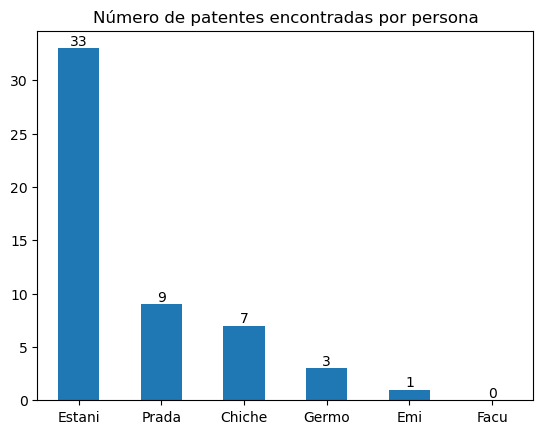

In [2]:
def plot_number_found(df: pd.DataFrame):
    # Plot the number of times each person found a patent ordered by the number of times they found a patent in descending order
    found_by = df.groupby("encontradaPor").size().sort_values(ascending=False)

    # Add Facu to the list of people :)
    found_by["Facu"] = 0

    found_by.plot(kind="bar")

    # Remove the x label
    plt.xlabel("")

    # Rotate the x labels
    plt.xticks(rotation=0)

    # Put the number of times found on top of the bars
    for i in range(len(found_by)):
        plt.text(
            i,
            found_by.values[i] + 0.3,
            found_by.values[i],
            ha="center",
        )

    plt.title("Número de patentes encontradas por persona")
    plt.show()

plot_number_found(df.copy(deep=True))

### Patentes encontradas a lo largo del tiempo, marcando el mejor día

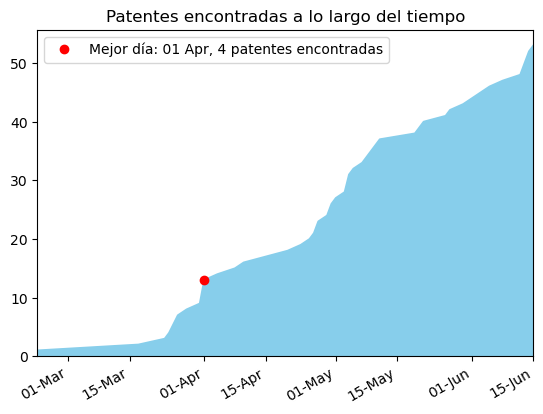

In [3]:
# Area chart
def plot_found_progress(df: pd.DataFrame):
    # Plot the number of patents found over time
    found_over_time = df.groupby("fecha").size().cumsum()

    found_over_time.plot(kind="area", color="skyblue")

    # Remove the x label
    plt.xlabel("")

    # Change the date format to show number of day and name of the month
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%d-%b"))

    # End the x axis at the last date
    plt.xlim(found_over_time.index[0], found_over_time.index[-1])

    # Get current x-ticks and add the last date if not already present
    xticks = plt.gca().get_xticks()
    last_date = found_over_time.index[-1]
    if plt.matplotlib.dates.date2num(last_date) not in xticks:
        # Remove the last x-tick and add the last date if the difference between the last two dates less than 10 days
        if (last_date - found_over_time.index[-2]).days < 10:
            xticks = xticks[:-1]
        xticks = list(xticks) + [plt.matplotlib.dates.date2num(last_date)]
        plt.gca().set_xticks(xticks)

    # Mark the best day in which the most patents were found with a red dot
    best_day = df.groupby("fecha").size().idxmax()
    best_day_formatted = best_day.strftime("%d %b")
    patents_found = df.groupby("fecha").size().max()
    height_best_day = found_over_time.loc[best_day]

    plt.plot_date(
        best_day,
        height_best_day,
        color="red",
        label=f"Mejor día: {best_day_formatted}, {patents_found} patentes encontradas",
    )

    plt.legend(loc="upper left")
    plt.title("Patentes encontradas a lo largo del tiempo")
    plt.show()

plot_found_progress(df.copy(deep=True))

### Distribución de patentes encontradas por momento del día

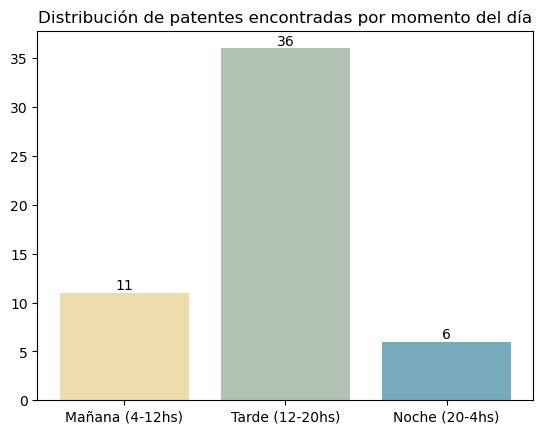

In [4]:
def plot_hour_distribution(df: pd.DataFrame):
    # Plot the distribution of the hour in which the patents were found
    found_at_hour = df.groupby(df["horaDelDia"]).size()

    # Add the missing hours
    for i in range(24):
        if i not in found_at_hour.index:
            found_at_hour[i] = 0

    found_at_hour = found_at_hour.sort_index()

    # Distribute in morning, afternoon and night
    morning = found_at_hour.loc[4:11].sum()
    afternoon = found_at_hour.loc[12:19].sum()
    night = found_at_hour.loc[20:23].sum() + found_at_hour.loc[0:3].sum()

    # Plot the distribution of the parts of the day with gradient colors
    plt.bar(
        ["Mañana (4-12hs)", "Tarde (12-20hs)", "Noche (20-4hs)"],
        [morning, afternoon, night],
        color=sns.color_palette("blend:#EDA,#7AB", 3),
    )

    # Put the number of patents found on top of the bars
    for i in range(3):
        plt.text(
            i,
            [morning, afternoon, night][i] + 0.3,
            [morning, afternoon, night][i],
            ha="center",
        )

    plt.title("Distribución de patentes encontradas por momento del día")
    plt.show()


plot_hour_distribution(df.copy(deep=True))

### Distribuición de patentes encontradas por día de la semana

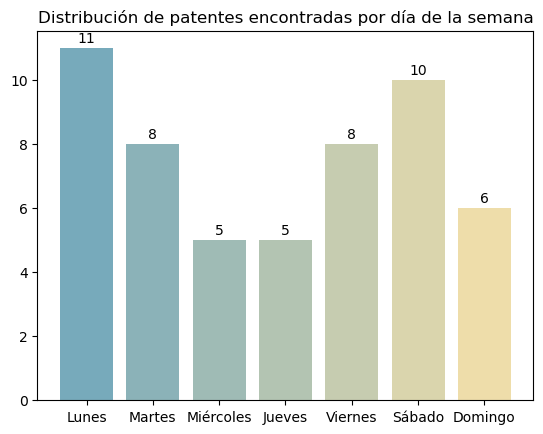

In [5]:
def plot_day_distribution(df: pd.DataFrame):
    # Plot the distribution of the day of the week in which the patents were found
    found_on_day = df.groupby(df["fecha"].dt.day_name()).size()

    day_order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Sort the days of the week
    found_on_day = found_on_day.reindex(day_order)

    # Add the missing days
    for day in day_order:
        if day not in found_on_day.index:
            found_on_day[day] = 0

    # Transform the index to spanish
    found_on_day.index = [
        "Lunes",
        "Martes",
        "Miércoles",
        "Jueves",
        "Viernes",
        "Sábado",
        "Domingo",
    ]

    # Plot the distribution of the days of the week with gradient colors
    plt.bar(
        found_on_day.index,
        found_on_day,
        color=sns.color_palette("blend:#7AB,#EDA", 7),
    )

    # Put the number of patents found on top of the bars
    for i in range(7):
        plt.text(
            i,
            found_on_day.values[i] + 0.2,
            found_on_day.values[i],
            ha="center",
        )

    plt.title("Distribución de patentes encontradas por día de la semana")
    plt.show()

plot_day_distribution(df.copy(deep=True))

### Distribución de marcas de autos encontradas

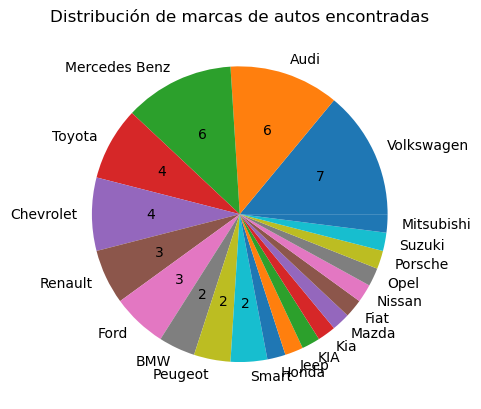

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


def car_brand_distribution(df: pd.DataFrame):
    # Plot the distribution of the car brands of the patents found
    car_brands = df.groupby("marca").size().sort_values(ascending=False)

    # Calculate the total number of items to use in the autopct function
    total = car_brands.sum()

    # Function to conditionally display the number
    def autopct(pct):
        absolute = round(pct / 100.0 * total)
        return str(absolute) if pct > 3 else ""

    # Plot the distribution of the car brands with gradient colors
    plt.pie(
        car_brands,
        labels=car_brands.index,
        autopct=autopct
    )

    plt.title("Distribución de marcas de autos encontradas")
    plt.show()


car_brand_distribution(df.copy(deep=True))

### Distribución de tipos de vehículos encontrados

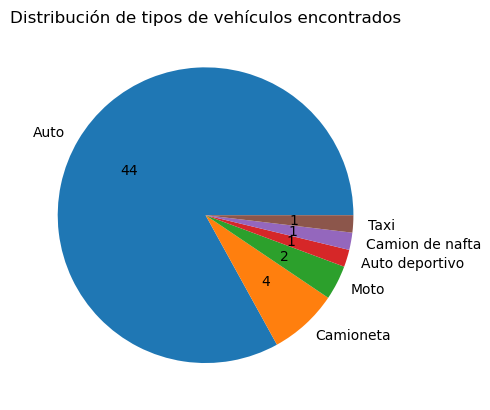

In [7]:
def car_type_distribution(df: pd.DataFrame):
    # Plot the distribution of the car types of the patents found
    car_types = df.groupby("vehiculo").size().sort_values(ascending=False)

    # Calculate the total number of items to use in the autopct function
    total = car_types.sum()

    # Function to conditionally display the number
    def autopct(pct):
        absolute = round(pct / 100.0 * total)
        return str(absolute) if pct > 0 else ""

    # Plot the distribution of the car types with gradient colors
    plt.pie(
        car_types,
        labels=car_types.index,
        autopct=autopct
    )

    plt.title("Distribución de tipos de vehículos encontrados")
    plt.show()

car_type_distribution(df.copy(deep=True))

## Estadisticas Copadas

### Mejor racha de patentes encontradas seguidas

In [8]:
def plot_top_3_streaks():
    pass

### Patentes totales vistas por probabilidad

### Proyección de cuando vamos a terminar de encontrar todas las patentes

### Cuanto pagaría una apuesta de quien encuentra la próxima patente

### Predicción de distribución para cuando lleguemos a 100 patentes encontradas

## Correlaciones

Aún sin completar

## Estadisticas por fuera de los datos

### Patentes adulteradas

### Pifies de mandar la patente incorrecta